This analysis examines customer usage patterns and revenue for **Megaline**, a telecom company offering two prepaid plans: **Surf** and **Ultimate**. The business goal is to determine which plan is more profitable and whether regional factors, such as living in the NY/NJ area, influence revenue.

The dataset includes information on customer demographics, plan details, and monthly usage for calls, messages, and internet data. We will clean and prepare the data, calculate revenue, compare performance between plans, and run statistical tests to check if observed differences are significant.

The results will guide marketing and pricing strategies for Megaline.

> **Note:**  
> This notebook was developed on the TripleTen platform using internal datasets that are not included in this public repository.  
> All charts, tables, and outputs have been preserved for reference, but the original data files are not available here.  
> Attempting to re-run the notebook outside of the TripleTen environment will result in file loading errors.


In [1]:
# Loading all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats



Load the raw datasets for users, calls, messages, and internet usage. These will be merged later to create a complete view of each customer's activity.

In [2]:
try:
    calls_df = pd.read_csv('/datasets/megaline_calls.csv')
    internet_df = pd.read_csv('/datasets/megaline_internet.csv')
    messages_df = pd.read_csv('/datasets/megaline_messages.csv')
    plans_df = pd.read_csv('/datasets/megaline_plans.csv')
    users_df = pd.read_csv('/datasets/megaline_users.csv')
    print("All datasets loaded successfully.")
except FileNotFoundError:
    print("One or more dataset files were not found. This notebook was created on the TripleTen platform, and the data is not included in this repository.")


Show updated column names and types to confirm the cleanup worked as expected.

In [3]:
# Print the general/summary information about the plans' DataFrame
plans_df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


Preview the first few rows to confirm the dataset loaded correctly and to get an initial sense of its structure.

In [4]:
# Print a sample of data for plans
plans_df.head()


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


Standardize the plan table's column names to a clean, consistent format so they are easy to reference in code.

In [5]:

plans_df.columns=plans_df.columns.str.lower()
plans_df.columns=plans_df.columns.str.replace(' ','_')
plans_df.columns


Index(['messages_included', 'mb_per_month_included', 'minutes_included',
       'usd_monthly_pay', 'usd_per_gb', 'usd_per_message', 'usd_per_minute',
       'plan_name'],
      dtype='object')

Show updated column names and types to confirm the cleanup worked as expected.

In [6]:
# Print the general/summary information about the users' DataFrame

users_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Preview the first few rows to confirm the dataset loaded correctly and to get an initial sense of its structure.

In [7]:
# Print a sample of data for users
users_df.head()


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


From the sample above, we can observe the structure and content of the dataset. Key points to note:
- All expected columns are present and populated for most records.
- Some columns contain missing values (e.g., `churn_date`), likely indicating customers who are still active.
- Date fields may need conversion to proper datetime format.
- Text fields such as `city` contain both city and region codes, which could be split for more granular geographic analysis.
- Numerical fields (e.g., `age`) appear reasonable, but a full check for outliers or invalid values is recommended.

In [8]:
users_df.columns

Index(['user_id', 'first_name', 'last_name', 'age', 'city', 'reg_date', 'plan',
       'churn_date'],
      dtype='object')

Show updated column names and types to confirm the cleanup worked as expected.

In [9]:
users_df['reg_date'] = pd.to_datetime(users_df['reg_date'])
users_df['churn_date'] = pd.to_datetime(users_df['churn_date'])
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


Show updated column names and types to confirm the cleanup worked as expected.

In [10]:
# Print the general/summary information about the calls' DataFrame

calls_df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


Preview the first few rows to confirm the dataset loaded correctly and to get an initial sense of its structure.

In [11]:
# Print a sample of data for calls
calls_df.head()


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


Calls data looks good, call_date is stored as object type and should be converted to datetime. 

Calculate monthly revenue for each customer by adding the base plan cost to any overage charges for minutes, messages, and data.

In [12]:
calls_df.columns
calls_df['duration'] = calls_df['duration'].apply(np.ceil)
calls_df

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,9.0
1,1000_145,1000,2018-12-27,14.0
2,1000_247,1000,2018-12-27,15.0
3,1000_309,1000,2018-12-28,6.0
4,1000_380,1000,2018-12-30,5.0
...,...,...,...,...
137730,1499_199,1499,2018-11-21,9.0
137731,1499_200,1499,2018-10-20,11.0
137732,1499_201,1499,2018-09-21,9.0
137733,1499_202,1499,2018-10-10,1.0


Show updated column names and types to confirm the cleanup worked as expected.

In [13]:
calls_df['call_date'] = pd.to_datetime(calls_df['call_date'])
calls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


Show updated column names and types to confirm the cleanup worked as expected.

In [14]:
# Print the general/summary information about the messages' DataFrame

messages_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


Preview the first few rows to confirm the dataset loaded correctly and to get an initial sense of its structure.

In [15]:
# Print a sample of data for messages
messages_df.head()


,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


Calls data looks good, message_date is stored as object type and should be converted to datetime. 

In [16]:
messages_df.columns

Index(['id', 'user_id', 'message_date'], dtype='object')

Show updated column names and types to confirm the cleanup worked as expected.

In [17]:
messages_df['message_date'] = pd.to_datetime(messages_df['message_date'])
messages_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


Show updated column names and types to confirm the cleanup worked as expected.

In [18]:
# Print the general/summary information about the internet DataFrame
internet_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


Preview the first few rows to confirm the dataset loaded correctly and to get an initial sense of its structure.

In [19]:
# Print a sample of data for the internet traffic
internet_df.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


Data in internet_df looks good, session_date is stored as object type and should be converted to datetime.

In [20]:
internet_df.columns


Index(['id', 'user_id', 'session_date', 'mb_used'], dtype='object')

Show updated column names and types to confirm the cleanup worked as expected.

In [21]:
internet_df['session_date'] = pd.to_datetime(internet_df['session_date'])
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [22]:
# Print out the plan conditions and make sure they are clear for you

plans_df


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [23]:
# Calculate the number of calls made by each user per month. Save the result.

calls_df['month'] = calls_df['call_date'].dt.month
calls_df['year'] = calls_df['call_date'].dt.year
calls_per_month = calls_df.groupby(['user_id', 'month']).size().reset_index(name='num_calls')

In [24]:
# Calculate the amount of minutes spent by each user per month. Save the result.
minutes_per_month = calls_df.groupby(['user_id', 'month'])['duration'].sum().reset_index(name='total_minutes')


In [25]:
# Calculate the number of messages sent by each user per month. Save the result.
messages_df['month'] = messages_df['message_date'].dt.month
messages_df['year'] = messages_df['message_date'].dt.year
messages_per_month = messages_df.groupby(['user_id', 'year', 'month']).size().reset_index(name='message_count')


In [26]:
# Calculate the volume of internet traffic used by each user per month. Save the result.

internet_df['year'] = internet_df['session_date'].dt.year
internet_df['month'] = internet_df['session_date'].dt.month

internet_per_month = internet_df.groupby(['user_id', 'year', 'month'])['mb_used'].sum().reset_index(name='total_traffic_mb')



Preview the first few rows to confirm the dataset loaded correctly and to get an initial sense of its structure.

In [27]:


# Start with minutes_per_month and calls_per_month (assuming calls_per_month contain call counts)
final_df = pd.merge(minutes_per_month, calls_per_month, on=['user_id', 'month'], how='outer')

# Merge with messages_per_month
final_df = pd.merge(final_df, messages_per_month, on=['user_id', 'month'], how='outer')

# Merge with internet_per_month
final_df = pd.merge(final_df, internet_per_month, on=['user_id', 'month'], how='outer')

# Merging user information from df_users into final_df
final_df = pd.merge(final_df, users_df[['user_id', 'plan']], on='user_id', how='left')

final_df = pd.merge(final_df, plans_df, left_on='plan', right_on='plan_name', how='left')

# Drop redundant columns
final_df.drop(columns=['plan_name'], inplace=True)

# Handling any NaN values that may result from the merge (assuming 0 where data is missing)
final_df.fillna(0, inplace=True)

# Print the first few rows of the merged DataFrame to verify
print(final_df.head())


   user_id  month  total_minutes  num_calls  year_x  message_count  year_y  \
0     1000     12          124.0       16.0  2018.0           11.0  2018.0   
1     1001      8          182.0       27.0  2018.0           30.0  2018.0   
2     1001      9          315.0       49.0  2018.0           44.0  2018.0   
3     1001     10          393.0       65.0  2018.0           53.0  2018.0   
4     1001     11          426.0       64.0  2018.0           36.0  2018.0   

   total_traffic_mb      plan  messages_included  mb_per_month_included  \
0           1901.47  ultimate               1000                  30720   
1           6919.15      surf                 50                  15360   
2          13314.82      surf                 50                  15360   
3          22330.49      surf                 50                  15360   
4          18504.30      surf                 50                  15360   

   minutes_included  usd_monthly_pay  usd_per_gb  usd_per_message  \
0          

In [28]:
final_df.columns

Index(['user_id', 'month', 'total_minutes', 'num_calls', 'year_x',
       'message_count', 'year_y', 'total_traffic_mb', 'plan',
       'messages_included', 'mb_per_month_included', 'minutes_included',
       'usd_monthly_pay', 'usd_per_gb', 'usd_per_message', 'usd_per_minute'],
      dtype='object')

In [29]:
print(final_df)

      user_id  month  total_minutes  num_calls  year_x  message_count  year_y  \
0        1000     12          124.0       16.0  2018.0           11.0  2018.0   
1        1001      8          182.0       27.0  2018.0           30.0  2018.0   
2        1001      9          315.0       49.0  2018.0           44.0  2018.0   
3        1001     10          393.0       65.0  2018.0           53.0  2018.0   
4        1001     11          426.0       64.0  2018.0           36.0  2018.0   
...       ...    ...            ...        ...     ...            ...     ...   
2288     1349     12            0.0        0.0  2018.0           61.0  2018.0   
2289     1361      5            0.0        0.0  2018.0            2.0  2018.0   
2290     1482     10            0.0        0.0  2018.0            2.0     0.0   
2291     1108     12            0.0        0.0     0.0            0.0  2018.0   
2292     1311      6            0.0        0.0     0.0            0.0  2018.0   

      total_traffic_mb     

Calculate monthly revenue for each customer by adding the base plan cost to any overage charges for minutes, messages, and data.

In [ ]:
# Calculate the monthly revenue from each user
def calculate_user_revenue(row):
    # Initialize the extra cost
    extra_minutes_cost = 0
    extra_messages_cost = 0
    extra_data_cost = 0
    
    # Check for extra minutes
    if row['total_minutes'] > row['minutes_included']:
        extra_minutes = row['total_minutes'] - row['minutes_included']
        extra_minutes_cost = extra_minutes * row['usd_per_minute']
        
    # Check for extra messages
    if row['message_count'] > row['messages_included']:
        extra_messages = row['message_count'] - row['messages_included']
        extra_messages_cost = extra_messages * row['usd_per_message']
        
    # Check for extra data (consider converting MB to GB if needed, and ensure to round up as the companies usually do)
    if row['total_traffic_mb'] > row['mb_per_month_included']:
        extra_gb = np.ceil((row['total_traffic_mb'] - row['mb_per_month_included']) / 1024) # 1024 MB in a GB
        extra_data_cost = extra_gb * row['usd_per_gb']
        
    # Calculate total monthly revenue from this user
    monthly_revenue = row['usd_monthly_pay'] + extra_minutes_cost + extra_messages_cost + extra_data_cost
    return monthly_revenue
final_df['monthly_revenue'] = final_df.apply(calculate_user_revenue, axis=1)
final_df

,user_id,month,total_minutes,num_calls,year_x,message_count,year_y,total_traffic_mb,plan,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,monthly_revenue
0,1000,12,124.0,16.0,2018.0,11.0,2018.0,1901.47,ultimate,1000,30720,3000,70,7,0.01,0.01,70.00
1,1001,8,182.0,27.0,2018.0,30.0,2018.0,6919.15,surf,50,15360,500,20,10,0.03,0.03,20.00
2,1001,9,315.0,49.0,2018.0,44.0,2018.0,13314.82,surf,50,15360,500,20,10,0.03,0.03,20.00
3,1001,10,393.0,65.0,2018.0,53.0,2018.0,22330.49,surf,50,15360,500,20,10,0.03,0.03,90.09
4,1001,11,426.0,64.0,2018.0,36.0,2018.0,18504.30,surf,50,15360,500,20,10,0.03,0.03,60.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1349,12,0.0,0.0,2018.0,61.0,2018.0,13039.91,surf,50,15360,500,20,10,0.03,0.03,20.33
2289,1361,5,0.0,0.0,2018.0,2.0,2018.0,1519.69,surf,50,15360,500,20,10,0.03,0.03,20.00
2290,1482,10,0.0,0.0,2018.0,2.0,0.0,0.00,ultimate,1000,30720,3000,70,7,0.01,0.01,70.00
2291,1108,12,0.0,0.0,0.0,0.0,2018.0,233.17,ultimate,1000,30720,3000,70,7,0.01,0.01,70.00


In [31]:
final_df.columns

Index(['user_id', 'month', 'total_minutes', 'num_calls', 'year_x',
       'message_count', 'year_y', 'total_traffic_mb', 'plan',
       'messages_included', 'mb_per_month_included', 'minutes_included',
       'usd_monthly_pay', 'usd_per_gb', 'usd_per_message', 'usd_per_minute',
       'monthly_revenue'],
      dtype='object')

Group the data by plan type and compute average usage and revenue to compare plan performance.

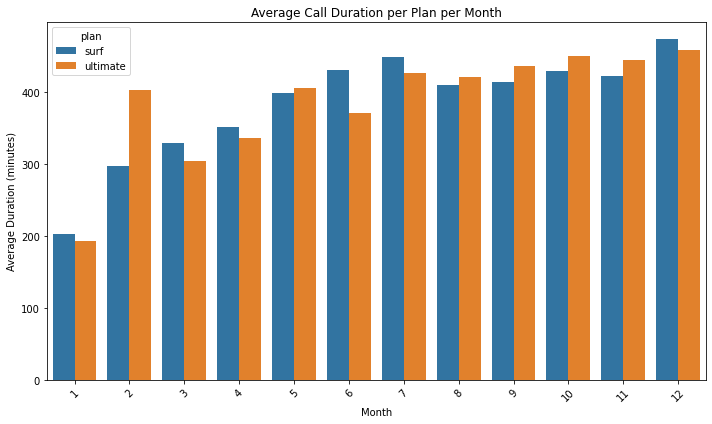

In [32]:
# Compare average duration of calls per each plan per each distinct month. Plot a bar plat to visualize it.

# Aggregate data to calculate average call duration per plan per month

average_call_duration = final_df.groupby(['plan', 'month'])['total_minutes'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='month', y='total_minutes', hue='plan', data=average_call_duration)
plt.title('Average Call Duration per Plan per Month')
plt.xlabel('Month')
plt.ylabel('Average Duration (minutes)')
plt.xticks(rotation=45)  # Rotate month labels for better readability
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()

Call duration follows a similar trend and across both plans throughout the year; it generally increases for the first 6-7 months and levels off until the end of the year. 

Visualize the data to identify patterns and differences in usage or revenue across plans or regions.

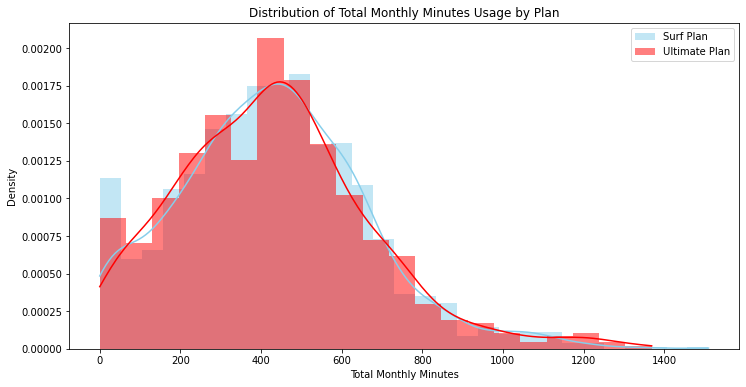

In [33]:
# Compare the number of minutes users of each plan require each month. Plot a histogram.

# Filter data by plan for visualization
surf_users = final_df[final_df['plan'] == 'surf']['total_minutes']
ultimate_users = final_df[final_df['plan'] == 'ultimate']['total_minutes']

# Set up the matplotlib figure
plt.figure(figsize=(12, 6))

# Plot a histogram for each plan
sns.histplot(surf_users, color="skyblue", label='Surf Plan', kde=True, stat="density", linewidth=0)
sns.histplot(ultimate_users, color="red", label='Ultimate Plan', kde=True, stat="density", linewidth=0)

plt.title('Distribution of Total Monthly Minutes Usage by Plan')
plt.xlabel('Total Monthly Minutes')
plt.ylabel('Density')
plt.legend()
plt.show()

On average, users of both plans use about 400 minutes each month. 

In [34]:
# Calculate the mean and the variance of the monthly call duration
# Calculate the mean of monthly call duration
mean_call_duration = final_df['total_minutes'].mean()

# Calculate the variance of monthly call duration
variance_call_duration = final_df['total_minutes'].var()

print(f'Mean Monthly Call Duration: {mean_call_duration} minutes')
print(f'Variance of Monthly Call Duration: {variance_call_duration} minutes^2')


Mean Monthly Call Duration: 429.2834714348016 minutes
Variance of Monthly Call Duration: 55847.17877118995 minutes^2


In [35]:
final_df.columns

Index(['user_id', 'month', 'total_minutes', 'num_calls', 'year_x',
       'message_count', 'year_y', 'total_traffic_mb', 'plan',
       'messages_included', 'mb_per_month_included', 'minutes_included',
       'usd_monthly_pay', 'usd_per_gb', 'usd_per_message', 'usd_per_minute',
       'monthly_revenue'],
      dtype='object')

Visualize the data to identify patterns and differences in usage or revenue across plans or regions.

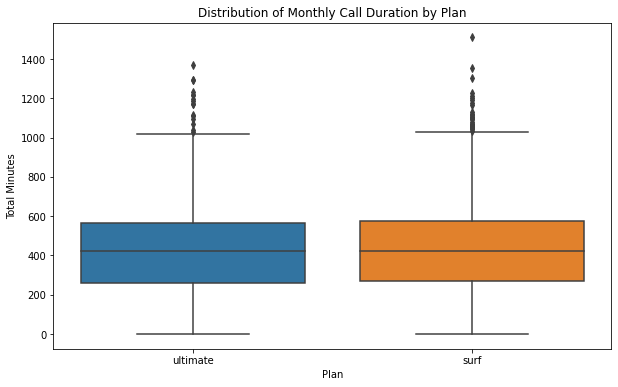

In [36]:
# Plot a boxplot to visualize the distribution of the monthly call duration
plt.figure(figsize=(10, 6))
sns.boxplot(data=final_df, x='plan', y='total_minutes')

plt.title('Distribution of Monthly Call Duration by Plan')
plt.xlabel('Plan')
plt.ylabel('Total Minutes')
plt.show()

Monthly call duration has a similar spread among both plans.

Visualize the data to identify patterns and differences in usage or revenue across plans or regions.

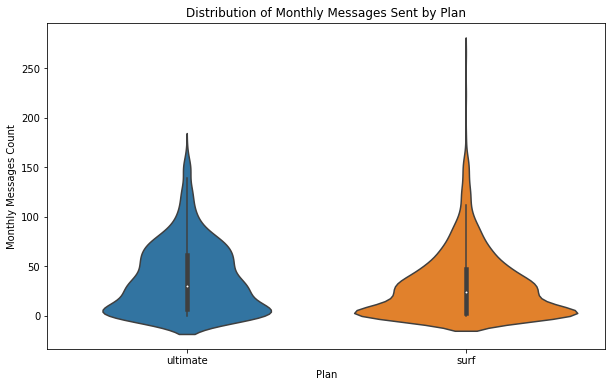

In [37]:
# Compare the number of messages users of each plan tend to send each month


plt.figure(figsize=(10, 6))
sns.violinplot(x='plan', y='message_count', data=final_df)
plt.title('Distribution of Monthly Messages Sent by Plan')
plt.xlabel('Plan')
plt.ylabel('Monthly Messages Count')
plt.show()


Users of both plans tend to send less than 50 messages each month. Surf users' monthly message count has a wider spread, with many using less than 25 messages and some using up to 275 minutes. 

Group the data by plan type and compute average usage and revenue to compare plan performance.

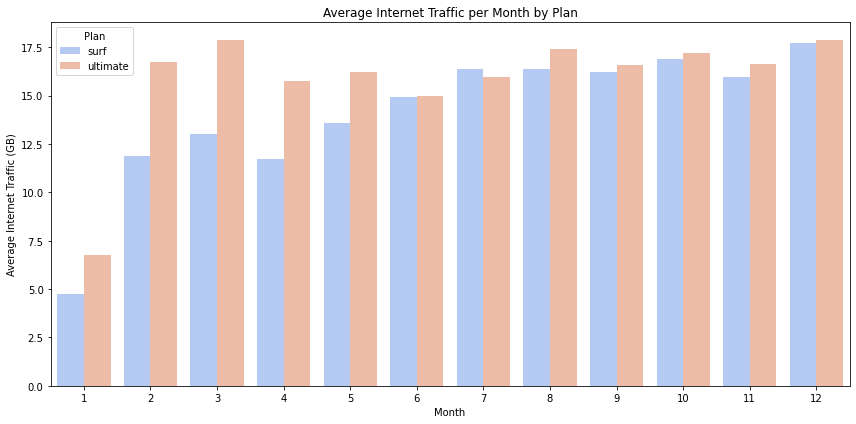

In [38]:
# Compare the amount of internet traffic consumed by users per plan
# Add a new column to the DataFrame for total data in GB
final_df['total_gb'] = final_df['total_traffic_mb'] / 1024
# Calculate the average internet traffic (GB) per plan per month
average_data_per_plan_month = final_df.groupby(['plan', 'month'])['total_gb'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=average_data_per_plan_month, x='month', y='total_gb', hue='plan', palette="coolwarm")
plt.title('Average Internet Traffic per Month by Plan')
plt.xlabel('Month')
plt.ylabel('Average Internet Traffic (GB)')
plt.legend(title='Plan')
plt.tight_layout()
plt.show()

Ultimate users tend to use slightly more internet traffic than Surf users. January has low internet traffic for both plans. Afterwards, monthly minutes generally trend upwards and level off over the year. 

Calculate monthly revenue for each customer by adding the base plan cost to any overage charges for minutes, messages, and data.

In [39]:
# Filter the DataFrame for each plan
surf_revenue = final_df[final_df['plan'] == 'surf']['monthly_revenue']
ultimate_revenue = final_df[final_df['plan'] == 'ultimate']['monthly_revenue']

# Calculate statistical metrics for the Surf plan
surf_mean = surf_revenue.mean()
surf_median = surf_revenue.median()
surf_variance = surf_revenue.var()
surf_std_dev = surf_revenue.std()

# Calculate statistical metrics for the Ultimate plan
ultimate_mean = ultimate_revenue.mean()
ultimate_median = ultimate_revenue.median()
ultimate_variance = ultimate_revenue.var()
ultimate_std_dev = ultimate_revenue.std()

# Printing results
print("Surf Plan Revenue Statistics:")
print(f"Mean: {surf_mean}, Median: {surf_median}, Variance: {surf_variance}, Standard Deviation: {surf_std_dev}\n")

print("Ultimate Plan Revenue Statistics:")
print(f"Mean: {ultimate_mean}, Median: {ultimate_median}, Variance: {ultimate_variance}, Standard Deviation: {ultimate_std_dev}")


Surf Plan Revenue Statistics:
Mean: 60.706408137317226, Median: 40.36, Variance: 3067.835152293878, Standard Deviation: 55.388041600095214

Ultimate Plan Revenue Statistics:
Mean: 72.31388888888888, Median: 70.0, Variance: 129.8484855509195, Standard Deviation: 11.395107965742119


The revenue statistics show that the Ultimate plan generates higher average monthly revenue per customer and has less variability compared to the Surf plan.

The average revenue per user is higher for those who use Ultimate. As the median is also higher for Ultimate, it more consistently brings in a higher profit per user. The higher variance of revenue for Surf users reflects the effect of overage charges on the spread of the plans revenue. 

A t-test will help determine if there is a significant difference between the average revenue of the two plans, as they are independent samples with normal distributions. 
H0: There is no statistically significant difference in average revenue between the two plans. 

H1: The average revenue from users of the Ultimate and Surf plans differs.

Calculate monthly revenue for each customer by adding the base plan cost to any overage charges for minutes, messages, and data.

In [40]:

surf_revenue = final_df[final_df['plan'] == 'surf']['monthly_revenue']
ultimate_revenue = final_df[final_df['plan'] == 'ultimate']['monthly_revenue']

# Performing the t-test
t_stat, p_value = stats.ttest_ind(surf_revenue, ultimate_revenue, equal_var=False)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Decision
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: The average revenue from users of the Ultimate and Surf plans differs.")
else:
    print("Fail to reject the null hypothesis: There is no statistically significant difference in average revenue between the two plans.")


T-statistic: -7.95209489133389, P-value: 3.17039054811355e-15
Reject the null hypothesis: The average revenue from users of the Ultimate and Surf plans differs.


A t-test will help determine if there is a significant difference between the average revenue of the NY-NJ region and the other regions in the dataset. The test assumes independent samples which are normally distributed and accounts for unequal variances.
/n
H0: There is no statistically significant difference in the average revenue based on region

H1: The average revenue from users in the NY-NJ area is different from that of users in other regions.

Merge the datasets on shared keys such as `user_id` so each record contains both plan details and usage activity.

In [41]:
final_df = pd.merge(final_df, users_df[['user_id', 'city']], on='user_id', how='left')
ny_nj_revenue = final_df[final_df['city'] == 'NY-NJ']['monthly_revenue']
other_revenue = final_df[final_df['city'] != 'NY-NJ']['monthly_revenue']

#t-test
t_stat, p_value = stats.ttest_ind(ny_nj_revenue, other_revenue, equal_var=False)
2/2
print(f"T-statistic: {t_stat}, P-value: {p_value}")

#decision
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: The average revenue from users in the NY-NJ area is different from that of users in other regions.")
else:
    print("Fail to reject the null hypothesis: There is no statistically significant difference in the average revenue based on region.")

T-statistic: nan, P-value: nan
Fail to reject the null hypothesis: There is no statistically significant difference in the average revenue based on region.


While both plans have similar call duration, minutes per month, and messages per month, average internet traffic was higher for Ultimate users. Ultimate consistently generates more revenue than Surf. For those customers in the NY-NJ region, there is no significant difference in revenue, compared to users outside of this region. 

## Conclusion

**Key Insights:**
- **Plan performance:** The Ultimate plan generates higher average monthly revenue per customer than the Surf plan, with less variability.
- **Statistical significance:** A two-sample t-test confirms that this revenue difference is statistically significant.
- **Regional effect:** Customers in the NY/NJ area do not show a statistically significant revenue difference compared to other regions.

**Business Recommendation:**
Focus marketing and retention efforts on the Ultimate plan for customers likely to have high usage, as it provides greater and more consistent revenue. Keep the Surf plan as a lower-cost option to attract budget-conscious customers. Do not prioritize region-based targeting, as location does not meaningfully impact revenue in this dataset.